In [4]:
# Install required packages
!pip install torch transformers pandas numpy scikit-learn tqdm accelerate


In [5]:
# Import libraries
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
MAX_LENGTH = 512
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5

def load_and_preprocess_data(file_path):
    """Load and preprocess the insurance claims data."""
    logger.info("Loading data...")
    df = pd.read_csv(file_path)

    # Combine relevant fields into a single text field
    df['text'] = df.apply(lambda row: f"Procedure Code: {row['Procedure Code']} " +
                                     f"Diagnosis Code: {row['Diagnosis Code']} " +
                                     f"Insurance Type: {row['Insurance Type']} " +
                                     f"Reason Code: {row['Reason Code']} " +
                                     f"Follow-up Required: {row['Follow-up Required']}", axis=1)

    # Convert outcome to binary (0 for Denied, 1 for Approved/Partially Paid)
    df['label'] = df['Outcome'].apply(lambda x: 0 if x == 'Denied' else 1)

    return df

def prepare_dataset(df, tokenizer):
    """Prepare the dataset for training."""
    logger.info("Preparing dataset...")

    # Split data into train and validation sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Tokenize the datasets
    train_encodings = tokenizer(train_df['text'].tolist(),
                              padding='max_length',
                              truncation=True,
                              max_length=MAX_LENGTH)

    val_encodings = tokenizer(val_df['text'].tolist(),
                            padding='max_length',
                            truncation=True,
                            max_length=MAX_LENGTH)

    # Convert to PyTorch datasets
    class ClaimsDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = ClaimsDataset(train_encodings, train_df['label'].values)
    val_dataset = ClaimsDataset(val_encodings, val_df['label'].values)

    return train_dataset, val_dataset

def compute_metrics(pred):
    """Compute metrics for evaluation."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [6]:

# Main training code
def main():
    # Load tokenizer and model
    logger.info("Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Load and preprocess data
    df = load_and_preprocess_data('claim_data.csv')

    # Prepare datasets
    train_dataset, val_dataset = prepare_dataset(df, tokenizer)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        learning_rate=LEARNING_RATE,
        save_total_limit=2,
        use_cpu=True  # Use CPU for training
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    logger.info("Starting training...")
    trainer.train()

    # Save the model
    logger.info("Saving model...")
    trainer.save_model('./final_model')
    tokenizer.save_pretrained('./final_model')

    # Evaluate on validation set
    logger.info("Evaluating model...")
    eval_results = trainer.evaluate()
    logger.info(f"Evaluation results: {eval_results}")

if __name__ == "__main__":
    main()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.756200
20,0.738100
30,0.734500
40,0.710100
50,0.683300
60,0.681900
70,0.628600
80,0.678300
90,0.639500
100,0.609500


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

def prepare_sample_claims():
    """Create multiple sample insurance claims for testing."""
    sample_claims = [
        {
            'Procedure Code': '99213',
            'Diagnosis Code': 'J45.909',
            'Insurance Type': 'PPO',
            'Reason Code': 'A1',
            'Follow-up Required': 'No'
        },
        {
            'Procedure Code': '99214',
            'Diagnosis Code': 'E11.9',
            'Insurance Type': 'HMO',
            'Reason Code': 'B2',
            'Follow-up Required': 'Yes'
        },
        {
            'Procedure Code': '99215',
            'Diagnosis Code': 'I10',
            'Insurance Type': 'Medicare',
            'Reason Code': 'C3',
            'Follow-up Required': 'No'
        }
    ]

    formatted_claims = []
    for claim in sample_claims:
        text = f"Procedure Code: {claim['Procedure Code']} " + \
               f"Diagnosis Code: {claim['Diagnosis Code']} " + \
               f"Insurance Type: {claim['Insurance Type']} " + \
               f"Reason Code: {claim['Reason Code']} " + \
               f"Follow-up Required: {claim['Follow-up Required']}"
        formatted_claims.append(text)

    return formatted_claims

def predict_claim(text, model, tokenizer):
    """Make a prediction for a single claim."""
    # Tokenize the text
    inputs = tokenizer(text,
                      padding='max_length',
                      truncation=True,
                      max_length=512,
                      return_tensors="pt")

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    return predicted_class, confidence

def main():
    # Load the saved model and tokenizer
    model_path = './final_model'
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Set model to evaluation mode
    model.eval()

    # Prepare sample claims
    sample_claims = prepare_sample_claims()

    # Test each claim
    print("\nTesting multiple sample claims:")
    print("-" * 50)

    for i, claim_text in enumerate(sample_claims, 1):
        print(f"\nTest Case {i}:")
        print("Claim Text:")
        print(claim_text)

        # Make prediction
        predicted_class, confidence = predict_claim(claim_text, model, tokenizer)

        # Print results
        outcome = "Denied" if predicted_class == 0 else "Approved/Partially Paid"
        print(f"\nPrediction Results:")
        print(f"Outcome: {outcome}")
        print(f"Confidence: {confidence:.2%}")
        print("-" * 50)

if __name__ == "__main__":
    main()

Loading model and tokenizer...

Testing multiple sample claims:
--------------------------------------------------

Test Case 1:
Claim Text:
Procedure Code: 99213 Diagnosis Code: J45.909 Insurance Type: PPO Reason Code: A1 Follow-up Required: No

Prediction Results:
Outcome: Approved/Partially Paid
Confidence: 68.12%
--------------------------------------------------

Test Case 2:
Claim Text:
Procedure Code: 99214 Diagnosis Code: E11.9 Insurance Type: HMO Reason Code: B2 Follow-up Required: Yes

Prediction Results:
Outcome: Approved/Partially Paid
Confidence: 66.85%
--------------------------------------------------

Test Case 3:
Claim Text:
Procedure Code: 99215 Diagnosis Code: I10 Insurance Type: Medicare Reason Code: C3 Follow-up Required: No

Prediction Results:
Outcome: Approved/Partially Paid
Confidence: 69.66%
--------------------------------------------------


Loading model and tokenizer...
Loading test data...
Making predictions...

Model Evaluation Metrics:
--------------------------------------------------
Accuracy: 66.90%
Precision: 66.90%
Recall: 100.00%
F1 Score: 80.17%

Detailed Classification Report:
--------------------------------------------------
                         precision    recall  f1-score   support

                 Denied       0.00      0.00      0.00       331
Approved/Partially Paid       0.67      1.00      0.80       669

               accuracy                           0.67      1000
              macro avg       0.33      0.50      0.40      1000
           weighted avg       0.45      0.67      0.54      1000


Plotting confusion matrix...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


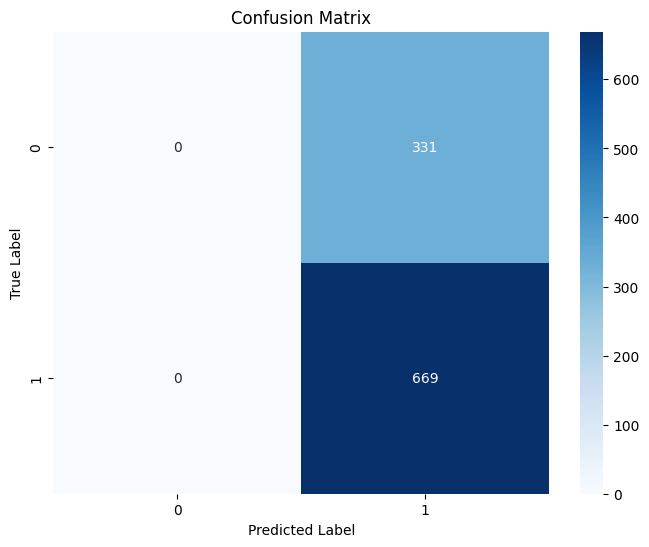


Average Confidence by Class:
--------------------------------------------------
Denied Claims: nan%
Approved/Partially Paid Claims: 68.51%


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def load_test_data(file_path):
    """Load and preprocess test data."""
    df = pd.read_csv(file_path)

    # Combine relevant fields into a single text field
    df['text'] = df.apply(lambda row: f"Procedure Code: {row['Procedure Code']} " +
                                     f"Diagnosis Code: {row['Diagnosis Code']} " +
                                     f"Insurance Type: {row['Insurance Type']} " +
                                     f"Reason Code: {row['Reason Code']} " +
                                     f"Follow-up Required: {row['Follow-up Required']}", axis=1)

    # Convert outcome to binary (0 for Denied, 1 for Approved/Partially Paid)
    df['label'] = df['Outcome'].apply(lambda x: 0 if x == 'Denied' else 1)

    return df

def predict_batch(texts, model, tokenizer, batch_size=16):
    """Make predictions for a batch of claims."""
    all_predictions = []
    all_confidences = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_texts,
                         padding='max_length',
                         truncation=True,
                         max_length=512,
                         return_tensors="pt")

        # Make predictions
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_classes = torch.argmax(predictions, dim=-1)
            confidences = torch.max(predictions, dim=-1)[0]

            all_predictions.extend(predicted_classes.tolist())
            all_confidences.extend(confidences.tolist())

    return all_predictions, all_confidences

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(model_path, test_data_path):
    """Evaluate model performance on test data."""
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    # Load test data
    print("Loading test data...")
    test_df = load_test_data(test_data_path)

    # Make predictions
    print("Making predictions...")
    predictions, confidences = predict_batch(test_df['text'].tolist(), model, tokenizer)

    # Calculate metrics
    accuracy = accuracy_score(test_df['label'], predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_df['label'], predictions, average='binary')

    # Print detailed metrics
    print("\nModel Evaluation Metrics:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    # Print classification report
    print("\nDetailed Classification Report:")
    print("-" * 50)
    print(classification_report(test_df['label'], predictions,
                              target_names=['Denied', 'Approved/Partially Paid']))

    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(test_df['label'], predictions)

    # Calculate average confidence by class
    denied_conf = np.mean([conf for pred, conf in zip(predictions, confidences) if pred == 0])
    approved_conf = np.mean([conf for pred, conf in zip(predictions, confidences) if pred == 1])

    print("\nAverage Confidence by Class:")
    print("-" * 50)
    print(f"Denied Claims: {denied_conf:.2%}")
    print(f"Approved/Partially Paid Claims: {approved_conf:.2%}")

if __name__ == "__main__":
    model_path = './final_model'
    test_data_path = 'claim_data.csv'  # Use your test data file
    evaluate_model(model_path, test_data_path)